# Some NLP fun with spooky authors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy


nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
sns.set_style("darkgrid")

In [29]:
train = pd.read_csv("spooky.csv")
Y = train.author

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


In [31]:
train.head(5)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


## EDA

In [32]:
train["author"].value_counts(normalize=True)

EAP    0.403494
MWS    0.308698
HPL    0.287808
Name: author, dtype: float64

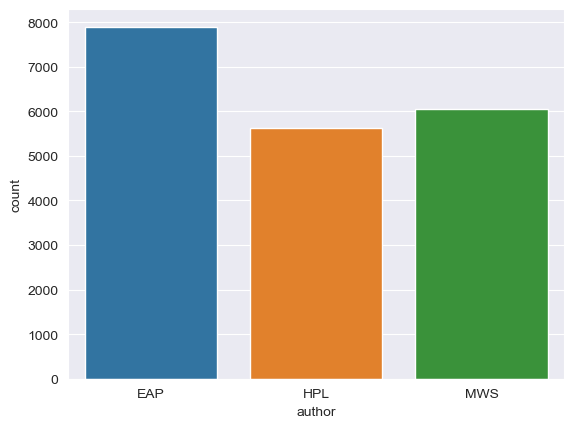

In [33]:
sns.countplot(x=train.author)
plt.show()

In [34]:
df = train.copy()

In [35]:
df["len"] = train["text"].str.len()

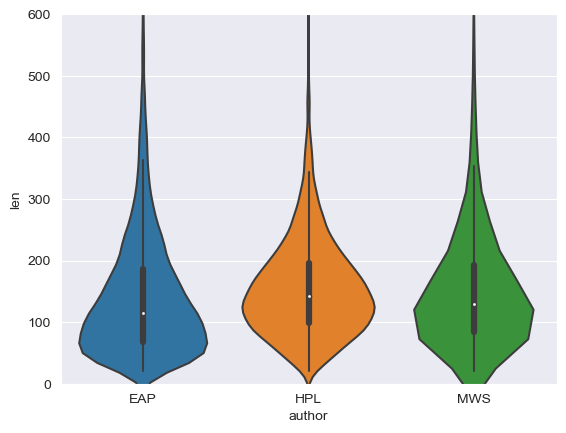

In [36]:
sns.violinplot(x=df.author, y=df.len)
plt.ylim(0, 600)
plt.show()

In [37]:
df["punc"] = train.text.str.findall("[^\s\w]").apply(len)

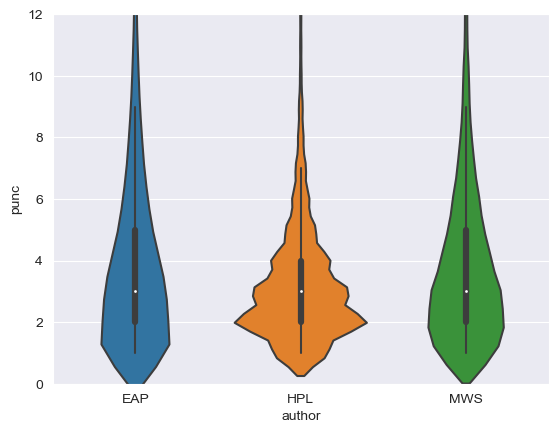

In [38]:
sns.violinplot(x=df.author, y=df.punc)
plt.ylim(0, 12)
plt.show()

In [39]:
df["words_count"] = df.text.str.findall("\w+").apply(len)

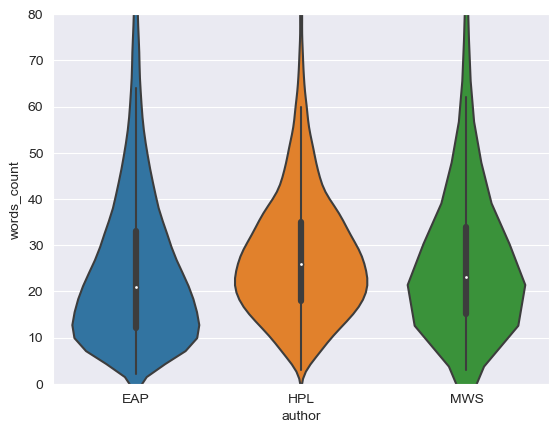

In [40]:
sns.violinplot(x=df.author, y=df["words_count"])
plt.ylim(0, 80)
plt.show()

In [41]:
df["stopwords"] = df.text.str.split().apply(lambda x: sum(map(lambda y: y in stopwords, x)))

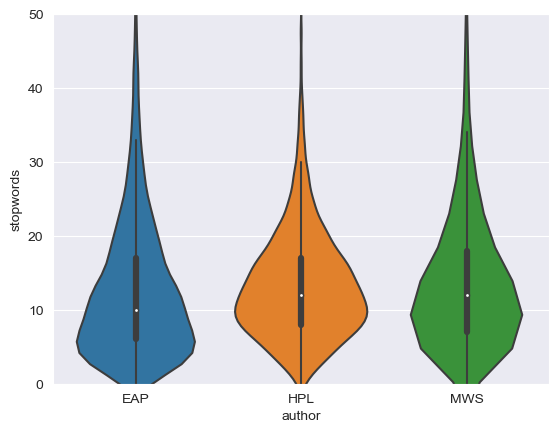

In [42]:
sns.violinplot(x=df.author, y=df["stopwords"])
plt.ylim(0, 50)
plt.show()

In [43]:
df["capital"] = df.text.str.split().apply(lambda x: sum(map(lambda y: y.istitle(), x)) - 1)

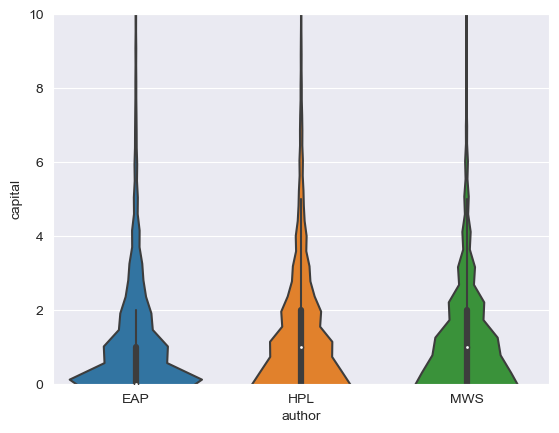

In [44]:
sns.violinplot(x=df.author, y=df["capital"])
plt.ylim(0, 10)
plt.show()

In [45]:
df["unique"] = df.text.str.lower().str.split().apply(lambda x: len(np.unique(x)))

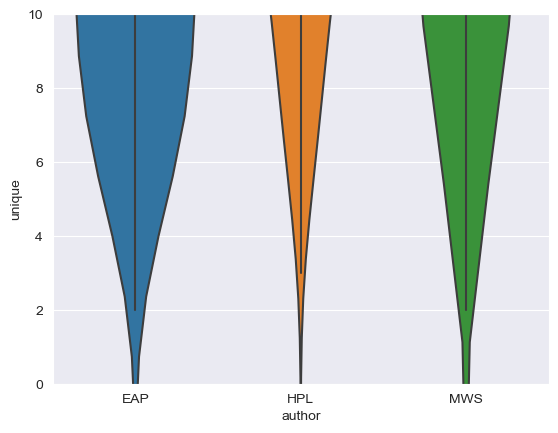

In [46]:
sns.violinplot(x=df.author, y=df["unique"])
plt.ylim(0, 10)
plt.show()

In [47]:
df["word_average"] = df.text.str.lower().str.split().apply(lambda x: sum([len(y) for y in x])  / len(x))

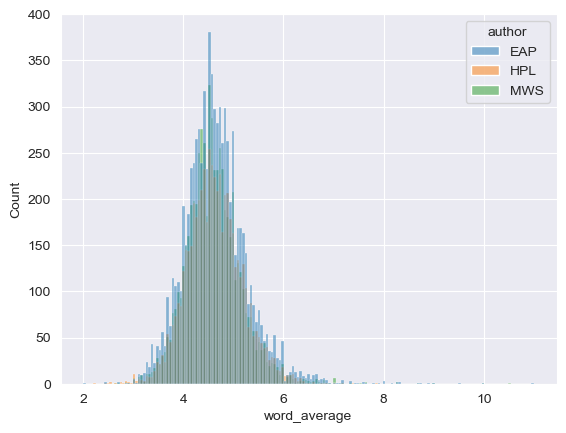

In [48]:
sns.histplot(data=df, x="word_average", hue="author", alpha=0.5)
plt.show()

## NLP preprocessing

In [49]:
def process_text(x):
    non_stop = [token.lemma_ for token in nlp(x) if token.lemma_ not in stopwords]
    return " ".join(non_stop)

In [50]:
def start(df_):
    return df_.copy()

def process_text(df_):
    df_.text = df_.text.str.replace("[^\w\s]", "", regex=True).str.lower().values
    return df_
    
def lemmatize(df_):
    texts = nlp.pipe(
        df_.text,
        n_process=4,
        disable=["parser", "ner"],
        batch_size=1000   
    )
    df_.text = [" ".join([token.lemma_ for token in doc if token.lemma_ not in stopwords]) for doc in texts]
    return df_

In [51]:
train_ = (
    train
    .pipe(start)
    .drop("id", axis=1)
    .pipe(process_text)
    .pipe(lemmatize)
)

In [52]:
train_.drop("author", axis=1, inplace=True)

In [53]:
train_

,text
0,process afford I mean ascertain dimension dung...
1,occur I fumbling mere mistake
2,left hand gold snuff box caper hill cut manner...
3,lovely spring look windsor terrace sixteen fer...
4,find gold superintendent abandon attempt perpl...
...,...
19574,I fancy I look eminent landscape painter build...
19575,lid clench spasm
19576,mais il faut agir frenchman faint outright
19577,item news like strike coolly receive


# Authors classification

In [82]:
import patsy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [55]:
new_df = df.iloc[:, 3:]

engineered = np.asarray(patsy.dmatrix("len*punc*words_count*stopwords*capital*unique*word_average", new_df))
new_engineered = StandardScaler().fit_transform(engineered)

e_train, e_test, ey_train, ey_test = train_test_split(new_engineered, Y, stratify=Y, test_size=0.25)
model = LogisticRegression(solver="newton-cg", multi_class="multinomial")
model.fit(e_train, ey_train)
print(accuracy_score(ey_test, model.predict(e_test)))

0.496220633299285


In [83]:
# tf-idf
transformer = TfidfVectorizer(min_df=5, max_df=0.5)
transformer.fit(train_.text)
transformed = transformer.transform(train_.text)

In [247]:
X_train, X_test, Y_train, Y_test = train_test_split(transformed, Y, test_size=0.25, stratify=Y)

In [248]:
log = LogisticRegression(multi_class='multinomial', solver="newton-cg")
log.fit(X_train, Y_train)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [249]:
accuracy_score(Y_test, log.predict(X_test))

0.8030643513789582

In [250]:
naive = MultinomialNB(alpha=0.8)
naive.fit(X_train.toarray(), Y_train)
predicted = naive.predict(X_test.toarray())
accuracy_score(Y_test, predicted)

0.8100102145045965

In [251]:
rf = RandomForestClassifier(n_estimators=200, n_jobs=4)
rf.fit(X_train, Y_train)
predicted = rf.predict(X_test)
accuracy_score(Y_test, predicted)

0.7066394279877426

In [252]:
svc = LinearSVC()
svc.fit(X_train, Y_train)
predicted = svc.predict(X_test)
accuracy_score(Y_test, predicted)

0.8

In [209]:
array = confusion_matrix(Y_test, log.predict(X_test))

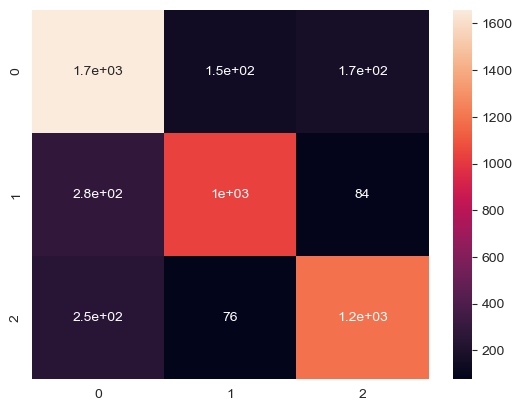

In [211]:
sns.heatmap(array, annot=True)
plt.show()

# Topic Modelling

In [84]:
from sklearn.decomposition import NMF

In [85]:
nmf = NMF(n_components=5, init="nndsvd")
nmf.fit(transformed)
W = nmf.transform(transformed)
print(W.shape)
H = nmf.components_
print(H.shape)

(19579, 5)
(5, 6482)


In [86]:
names = transformer.get_feature_names_out()

In [87]:
names

array(['abandon', 'abandonment', 'abaout', ..., 'zenith', 'zenobia',
       'zest'], dtype=object)

In [88]:
def get_top_names(topic_num, words=20):
    weights = H[topic_num, :]
    return names[weights.argsort()[::-1][:words]]

def get_top_docs(topic_num, docs=10):
    weights = W[:, topic_num]
    return train.text[weights.argsort()[::-1][:docs]]

In [89]:
def get_top_docs(topic_num, docs=10):
    weights = W[:, topic_num]
    return train.text[weights.argsort()[::-1][:docs]]

In [90]:
get_top_docs(0)

9215     Diotima approached the fountain seated herself...
11500    For the first time during many hours or perhap...
10939    They are gone for ever great as my power is I ...
18107    Oh no I will become wise I will study my own h...
4184     As for those who in your world knew not the lo...
17010    At first indeed this wanton spirit played a fa...
10564                      They left me in an hour's time.
4921     Your heart I fear, replied Diotima, was broken...
1157     Here he closed his eyes and placed his hand up...
3641     I do not die not having enjoyed life; for sixt...
Name: text, dtype: object

In [91]:
for i in range(5):
    print(get_top_names(i))

['time' 'find' 'day' 'long' 'eye' 'feel' 'look' 'life' 'love' 'night'
 'leave' 'hand' 'like' 'think' 'year' 'place' 'great' 'little' 'house'
 'hear']
['know' 'tell' 'world' 'believe' 'think' 'mean' 'god' 'reply' 'matter'
 'shall' 'expect' 'word' 'death' 'strange' 'want' 'suspect' 'hear'
 'people' 'let' 'friend']
['man' 'old' 'great' 'young' 'god' 'live' 'dream' 'tell' 'dead' 'world'
 'woman' 'animal' 'face' 'genius' 'bearded' 'good' 'mean' 'terrible' 'age'
 'city']
['come' 'night' 'tell' 'light' 'sound' 'home' 'street' 'sleep' 'hear'
 'fear' 'people' 'away' 'morning' 'day' 'moon' 'window' 'somebody' 'till'
 'close' 'change']
['thing' 'think' 'tell' 'like' 'speak' 'strange' 'earth' 'hear' 'world'
 've' 'old' 'live' 'sort' 'let' 'simple' 'read' 'state' 'try' 'unknown'
 'bad']


In [310]:
# na newsach

In [92]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    data_home="news",
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

news = dataset.data
labels = dataset.target

In [118]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)

news_tfidf = vectorizer.fit_transform(dataset.data)

In [119]:
nmf = NMF(n_components=4, init="nndsvd")
nmf.fit(news_tfidf)
W = nmf.transform(news_tfidf)
print(W.shape)
H = nmf.components_
print(H.shape)

(3387, 4)
(4, 7929)


In [120]:
names = vectorizer.get_feature_names_out()

In [121]:
def get_top_names(topic_num, words=20):
    weights = H[topic_num, :]
    return names[weights.argsort()[::-1][:words]]

def get_top_docs(topic_num, docs=10):
    weights = W[:, topic_num]
    return train.text[weights.argsort()[::-1][:docs]]

In [122]:
for i in range(4):
    print(get_top_names(i, words=10))

['people' 'don' 'think' 'just' 'like' 'say' 'religion' 'know' 'good'
 'right']
['graphics' 'thanks' 'image' 'file' 'files' 'format' 'program' 'gif' 'ftp'
 'know']
['space' 'nasa' 'shuttle' 'launch' 'orbit' 'moon' 'earth' 'mission'
 'satellite' 'lunar']
['god' 'jesus' 'bible' 'believe' 'christian' 'faith' 'belief' 'does'
 'christ' 'atheism']


In [123]:
for i in range(4):
    print(f"Topic {i+1}")
    for j in get_top_docs(i, docs=5):
        print(j)
        print("\n")
    print("\n\n")

Topic 1
At one period I thought he really intended to quack.


It is curious that although he differed so widely from the mass of Hispanicised and tribal Indians, Romero gave not the least impression of Caucasian blood.


The excellent administration of your affairs here is well understood in Paris, and I thought it just possible, you know "Yes, yes say no more or rather it is myself who should thank you for the commendable prudence you have displayed.


Many went up as high as Belfast to ensure a shorter passage, and then journeying south through Scotland, they were joined by the poorer natives of that country, and all poured with one consent into England.


Maternal affection had not rendered Idris selfish; at the beginning of our calamity she had, with thoughtless enthusiasm, devoted herself to the care of the sick and helpless.





Topic 2
Pausing, I succeeded with difficulty in raising it, whereupon there was revealed a black aperture, exhaling noxious fumes which caused my torch

# Text generating using Markov Model

In [56]:
from collections import defaultdict
from random import choices

In [57]:
# text preparation 
corpus = train.text.str.cat()

corpus = corpus.replace('“', ' " ')
corpus = corpus.replace('”', ' " ')
for spaced in ['.','-',',','!','?','(','—',')', '"', ';', ':']:
    corpus = corpus.replace(spaced, f' {spaced} ')
    
corpus_words = corpus.split(' ')
corpus_words = [word for word in corpus_words if word]

In [58]:
class MarkovChainText:
    
    def __init__(self, corpus, n_grams):
        self.corpus = corpus
        self.n_grams = n_grams
        self.model = {}
        
    def prepare_model(self):
        for i in range(0, len(self.corpus) - self.n_grams):
            curr_state = self.corpus[i:i + self.n_grams]
            next_state = self.corpus[i + self.n_grams]
            curr_state = ' '.join(curr_state)
            if curr_state not in self.model:
                self.model[curr_state] = defaultdict(int)
            self.model[curr_state][next_state] += 1
        
        for curr_state, list_next_states in self.model.items():
            tot_next_states = sum(list(list_next_states.values()))
            for next_state in list_next_states.keys():
                self.model[curr_state][next_state] /= tot_next_states
    
    def generate_text(self, start, size=10):
        story = start + ' '
        curr_state = ' '.join(start.split()[-self.n_grams:])
        for _ in range(size):
            transition_sequence = self.model[curr_state]
            next_state = choices(list(transition_sequence.keys()),
                                 list(transition_sequence.values()))
            story += next_state[0] + ' '
            curr_state = " ".join(curr_state.split()[1:] + next_state)
        return story[:-1]

In [72]:
markov_chain_text = MarkovChainText(corpus_words, 4)

In [73]:
markov_chain_text.prepare_model()

In [76]:
for i in range(10):
    print(markov_chain_text.generate_text("I am the only", size=25))

I am the only Survivor . The windows of the room had before been darkened , and I felt I must keep the image of his wild , watery
I am the only Survivor . The windows of the room had , as usual , been suffered to exist . I agree with Buffon with Hogarth it is
I am the only Survivor . The windows of the room had , as usual , talked a great deal . It is a foolish sentiment for one who
I am the only Survivor . The windows of the room had before been darkened , and I felt deeply moved despite my rational beliefs . When we arrived
I am the only Survivor . The windows of the room had before been darkened , and I felt beyond a doubt that neither Romero nor I had left
I am the only Survivor . The windows of the room had before been darkened , and I felt a singular sense of disquiet in looking at the lonely
I am the only Survivor . The windows of the room had , as usual , and talked without dread of our future plans . The jog trot movement
I am the only Survivor . The windows of the room had , 

## Python library

In [77]:
import markovify

In [78]:
model = markovify.Text(train.text, state_size=3)

In [79]:
for i in range(10):
    print(f"{i+1}: {model.make_sentence()}")
    print("\n")

1: Then the mark of suspicion, the object of which I had long been alienated, wrapt her senses in delight, her mind in placidity.


2: I know what ought to be done, Jupiter's voice was again heard.


3: They were as baffling as the hordes of great bats which haunted the old house, the crypt behind it, and the Museum of Fine Arts wouldn't accept it as a happy omen of ultimate success.


4: None


5: The remaining two had gone back after Obed Marsh was dead.


6: Right at the front door, in a high and steady purpose, elevated me; a strange joy filled my heart.


7: The frigidity of the apartment was now sensibly diminishing, and at about a.m. the whole house as it was, dreaded and deserted.


8: When they found themselves discovered they discharged their muskets, and some came to the horizon, and hints of the woman, appeared the deadliest insult.


9: Having noticed these particulars, and some others, I again turned my eyes away, while my heart sickened within me.


10: This belief had e

In [80]:
model.make_sentence_with_start("I am the")

'I am the cause of its twofold repetition, who would be the last time.'